# Models

In [32]:
#Dependencies
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
## import libraries for ARIMA
import fbprophet
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
#show current versions
print("Numpy Version", np.__version__)
print("Pandas Version", pd.__version__)
print("FBProphet Version", fbprophet.__version__)
print("Scikit Learn Version", sklearn.__version__)
print("Tensorflow Version:",tf.__version__)
print("Keras Version", keras.__version__)

Numpy Version 1.18.3
Pandas Version 1.0.3
FBProphet Version 0.6
Scikit Learn Version 0.22.2.post1
Tensorflow Version: 2.1.0
Keras Version 2.2.4-tf


## Datasets

In [33]:
path = "./datasets/"
#check location of files
os.getcwd()

'/Users/jacosta3/OneDrive - University of South Florida/Gerdau Projects/pft/submission'

In [34]:
# import data sets
weekly = pd.read_csv(path+'structuralweekly_with_indicators.csv', dtype={'year':object,'month':object, 'shipment_tons':float, 'production_tons':float,                                       'fed_construction$B':float, 'state_local_construction$B':float,                     
                          'carbon_bar_ship_usa':float, 'carbon_bar_ship_canada':float, 'structural_ship_usa':float,
                          'structural_ship_canada':float, 'chicago_scrap$ST':float})
monthly = pd.read_csv(path+'structuralmonthly_with_indicators.csv', dtype={'year':object,'month':object, 'shipment_tons':float, 'production_tons':float,                                      'fed_construction$B':float, 'state_local_construction$B':float,                     
                           'carbon_bar_ship_usa':float, 'carbon_bar_ship_canada':float, 'structural_ship_usa':float,
                           'structural_ship_canada':float, 'chicago_scrap$ST':float})

## Data Prep

In [35]:
#Changing data types
weekly.calendar_day = weekly.calendar_day.astype('datetime64')
monthly.calendar_day = monthly.calendar_day.astype('datetime64')

### Weekly

In [36]:
# Splitting by years with uneven data points per year
# Source: https://stackoverflow.com/questions/58069691/how-to-create-a-train-test-split-of-time-series-data-by-year
year_list = weekly['year'].unique().tolist()
weekly_splits = {'train': [], 'test': []}

for idx, yr in enumerate(year_list[:-1]):
    train_yr = year_list[:idx+1]
    test_yr = [year_list[idx+1]]
    print('TRAIN: ', train_yr, 'TEST: ',test_yr)

    weekly_splits['train'].append(weekly.loc[weekly.year.isin(train_yr), :])
    weekly_splits['test'].append(weekly.loc[weekly.year.isin(test_yr), :])

print('\n')
# Exception, we only have 3 series (2019 + 2020) should be aggregated(if 2020 is used)
print("Size of the Train-Test Splits:")
print("Train 2016-18:",weekly_splits['train'][2].shape[0])
print("Test  2019-20:",weekly_splits['test'][2].shape[0]+weekly_splits['test'][3].shape[0])

TRAIN:  ['2016'] TEST:  ['2017']
TRAIN:  ['2016', '2017'] TEST:  ['2018']
TRAIN:  ['2016', '2017', '2018'] TEST:  ['2019']
TRAIN:  ['2016', '2017', '2018', '2019'] TEST:  ['2020']


Size of the Train-Test Splits:
Train 2016-18: 9455
Test  2019-20: 3064


## Metrics
- Source: https://medium.com/@joydeepubuntu/common-metrics-for-time-series-analysis-f3ca4b29fe42

In [38]:
def score_model(test_y, test_x, model, api=None,):
    '''
    scoring function to be used across model.
    parameters - 
        test_y: dataframe with dependent located in the last row
        test_x: dataframe with independent variables for model ingestion
        model: trained model
        api: 'tf':tensorflow, 'prophet':facebook prophet
    notes:
        for prophet input the 'future' df as test_x, that function will filter out the needed dataframe
    '''
    try:
         test_y = test_y.iloc[:,-1].to_numpy()
    except:
        print('test_y is a numpy array')
    if api == 'tf':
        pred_y = scale.inverse_transform(model.predict(test_x))[:,-1]
        test_y = scale.inverse_transform(test_y)
    elif api == 'prophet':
        forecast = prophet.predict(test_x)
        pred_y = forecast[forecast['ds'].dt.year >=2019][['ds','yhat']].rename(columns={'yhat':'y'}).iloc[:,-1].to_numpy()
    else:
        pred_y = model.predict(test_x)
    r2 = r2_score(test_y, pred_y)
    mae = mean_absolute_error(test_y,pred_y)
    rmse = mean_squared_error(test_y, pred_y, squared=False)
    four_pred = pred_y[4:] if api != 'tf' else pred_y
    four_test = test_y[4:] if api != 'tf' else test_y
    print("Test Scores:", )
    print("  Mean Absolute Error(MAE):",mae)
    print("  Root Mean Squared Error(RMSE):",rmse)
    print("  Coefficient of Determination(R2):",r2)
    print("Take 4 Sample Comparison:")
    print("  Predictions:", four_pred[0:4].round().astype(int).transpose())
    print("      Actuals:", four_test[0:4].astype(int).transpose())

# Prophet Univariate

In [39]:
#setting train (2016-2018), test (2019-2020)
train = weekly_splits['train'][2]
test = weekly_splits['test'][2].append(weekly_splits['test'][3], ignore_index=True)

Only one block for analysis: 4" ANG

In [40]:
#filtering block for analysis
train_block = train[train['block']=='4" ANG']
test_block = test[test['block']=='4" ANG']
#size decreases significantly - this could help/hurt
train_block.shape

(157, 18)

In [41]:
#setting up to univariate, prophet ingestion
train_block = train_block.rename(columns={'calendar_day':'ds', 'shipment_tons':'y'})[['ds','y']]
test_block = test_block.rename(columns={'calendar_day':'ds', 'shipment_tons':'y'})[['ds','y']]

#adding a floor for training set
# train_block['cap'] = 2000 #caps seem to have worsen model
# train_block['floor'] = 0 #floors seem to have worsen model

In [42]:
#peek at df
train_block.head(2)

,ds,y
16,2016-01-03,0.0
76,2016-01-10,297.0


### Set-Up & Fitting

In [43]:
#instantiating prophet model with an additive seasonal model, looking at yearly seasonality
prophet = Prophet(seasonality_mode="additive", yearly_seasonality=True,)

prophet.fit(train_block)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Predicting

In [44]:
#creates future calendar with actual dates in training & future dates (determined)
future = prophet.make_future_dataframe(periods=53, freq='W')

#setting up floor and cap
# future['cap'] = 2000 #caps seem to have worsen model
# future['floor'] = 0 #floor seem to have worsen model

In [45]:
#predict future
forecast = prophet.predict(future)

### View Forecast Plot & Components 

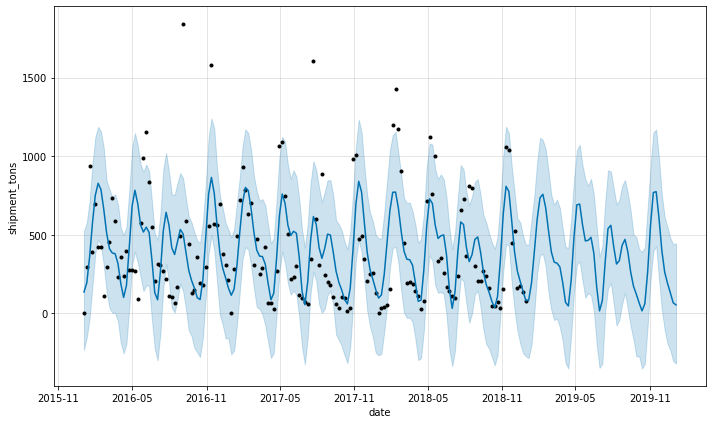

In [46]:
#plot projected shipments
#dark-blue: y_hat(prediction)
#shade-blue: uncertainty interval (range of values at 95%)
#dots: actual points
#dashed lines: cap and floor levels
prophet.plot(forecast, xlabel='date', ylabel='shipment_tons');

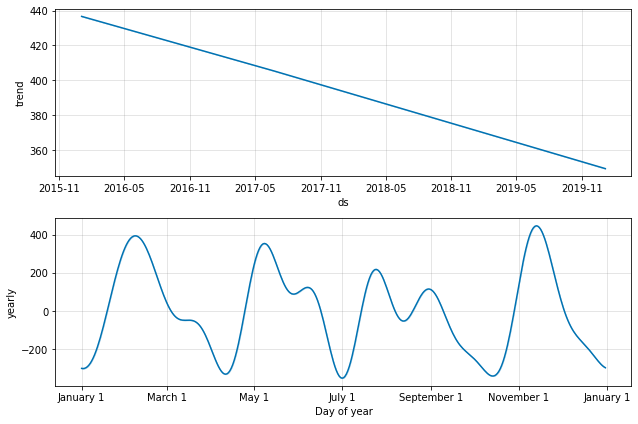

In [47]:
#look at components
#overall trend
#yearly seasonally presented
prophet.plot_components(forecast);

### Scoring

In [48]:
#Metrics provided by prophet make use of cross-validation and applies it to the known years in this case 2017-2018
evaluate = cross_validation(prophet, initial="52 W", horizon="4 W", period="1 W")
%time

INFO:fbprophet:Making 101 forecasts with cutoffs between 2017-01-01 00:00:00 and 2018-12-02 00:00:00
CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 10 µs


In [49]:
#see metrics scores using Prophet scorer
performance_metrics(evaluate)

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,7 days,137769.884349,371.173658,278.737816,0.670742,0.712871
1,14 days,174344.483846,417.545787,316.483349,0.748165,0.613861
2,21 days,182927.649323,427.700420,327.289126,0.771558,0.613861
3,28 days,183226.694307,428.049874,327.041020,0.773595,0.603960


### Cross-model evaluation
Predicting on 2019-20 test-set

In [50]:
#Scoring based on 2019-20 test set
score_model(test_block, future, prophet, api='prophet')

Test Scores:
  Mean Absolute Error(MAE): 216.66172387349795
  Root Mean Squared Error(RMSE): 291.39714114195937
  Coefficient of Determination(R2): 0.09333093387467506
Take 4 Sample Comparison:
  Predictions: [735 757 671 524]
      Actuals: [875 736 617 490]


# LSTM Univariate
Can only be used for one product at a time
- Sourced from: https://www.tensorflow.org/tutorials/structured_data/time_series

Prophet has given us a basic estimation of the types of predictions that can be achieved with a simple univariate model. The API is pretty easy to use and it has nice adaptations that could be used with more information about shut-downs at the mills, the beginning of production for a specific product etc. While the individual predictions don't seem too bad(small sample), the test score and Coefficient of Determination is not the most impressive 

## General Purpose Functions for LSTMs

In [51]:
#function to split univariate data for checking - helps match next upcoming point with the last input
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = [] #list of independent variables
  labels = [] #list of dependent variable

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [52]:
#function to split multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [53]:
#function to show the appropriate time-step
def create_time_steps(length):
  return list(range(-length, 0))

In [54]:
#function for plotting individual steps
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [55]:
#function to plot loss function charts
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

### Selecting Block 4" ANG

In [56]:
#Checking Univariate on 4" ANG
uni_data = weekly[weekly['block']=='4" ANG']['shipment_tons']
uni_data.index = weekly[weekly['block']=='4" ANG']['calendar_day']
#converting to dataframe
uni_data = pd.DataFrame(uni_data)
#checking shape
uni_data.shape

(210, 1)

### Train-Test Split

In [57]:
#check last index of 2018 -> use 157
print(uni_data.iloc[155:158,])
#setting index
TRAIN_SPLIT = 157

shipment_tons
calendar_day               
2018-12-23            138.0
2018-12-30             75.0
2019-01-06             53.0


### Scaling Data

In [58]:
#scaling data
scale = StandardScaler()
scale.fit(uni_data[:TRAIN_SPLIT])  #fitting on training sample only

StandardScaler(copy=True, with_mean=True, with_std=True)

In [59]:
uni_data_scaled = scale.transform(uni_data)

In [60]:
#Splitting time frames
univariate_past_history = 4
univariate_future_target = 0

#training set
x_train_uni, y_train_uni = univariate_data(uni_data_scaled, 0, TRAIN_SPLIT,
                                            univariate_past_history, 
                                            univariate_future_target)
#test set
x_test_uni, y_test_uni = univariate_data(uni_data_scaled, TRAIN_SPLIT, None,
                                            univariate_past_history, 
                                            univariate_future_target)

In [61]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target shipments to predict')
print (y_train_uni[0])

Single window of past history
[[-1.1178002 ]
 [-0.29474044]
 [ 1.47885635]
 [-0.03147216]]

 Target shipments to predict
[0.81098631]


### Setting up Model

In [62]:
#setting seed for reproductability
tf.random.set_seed(42)

In [63]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 12 # 12 weeks (3 mon)
BUFFER_SIZE = 300 # larger than dataset

#setting up memory and batch sizes
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#no cache, nor shuffle for validation
test_univariate = tf.data.Dataset.from_tensor_slices((x_test_uni, y_test_uni))
test_univariate = test_univariate.batch(BATCH_SIZE).repeat()

In [64]:
#architecture
uni_lstm = keras.models.Sequential([
    keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    keras.layers.Dense(1)
])

#compiler
uni_lstm.compile(optimizer='adam', loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError(),])

In [65]:
for x,y in test_univariate.take(1):
    print(uni_lstm.predict(x).shape)

(12, 1)


### Training Model

In [69]:
#fitting the model
EPOCHS=10 # Number of iterations over the training set (in this case full batch)
EVALUATION_INTERVAL=156 # size of the data for evaluation, in this case the whole data set for this block

uni_lstm.fit(train_univariate, epochs=EPOCHS,
                steps_per_epoch=EVALUATION_INTERVAL,
                validation_data=test_univariate,
                validation_steps=50)

Train for 156 steps, validate for 50 steps
Epoch 1/10
156/156 [==============================] - 1s 7ms/step - loss: 0.5966 - root_mean_squared_error: 0.9582 - val_loss: 0.5586 - val_root_mean_squared_error: 0.8363
Epoch 2/10
156/156 [==============================] - 1s 7ms/step - loss: 0.5585 - root_mean_squared_error: 0.9238 - val_loss: 0.4922 - val_root_mean_squared_error: 0.7818
Epoch 3/10
156/156 [==============================] - 1s 7ms/step - loss: 0.5266 - root_mean_squared_error: 0.8645 - val_loss: 0.4445 - val_root_mean_squared_error: 0.7218
Epoch 4/10
156/156 [==============================] - 1s 7ms/step - loss: 0.5039 - root_mean_squared_error: 0.8149 - val_loss: 0.4300 - val_root_mean_squared_error: 0.6904
Epoch 5/10
156/156 [==============================] - 1s 7ms/step - loss: 0.4856 - root_mean_squared_error: 0.7687 - val_loss: 0.4275 - val_root_mean_squared_error: 0.6618
Epoch 6/10
156/156 [==============================] - 1s 7ms/step - loss: 0.4717 - root_mean_squa

### Scoring Model

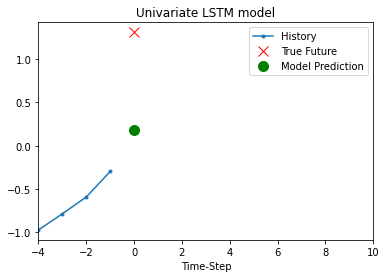

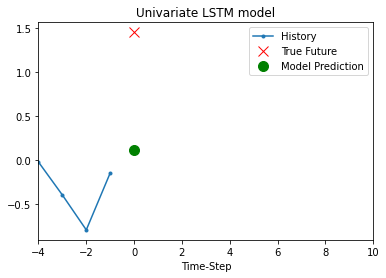

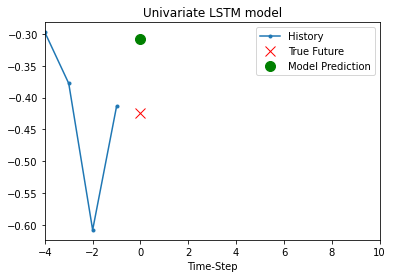

In [70]:
for x, y in test_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    uni_lstm.predict(x)[0]], 0, 'Univariate LSTM model')
  plot.show()

In [71]:
#Results from tensorflow
results = np.round(uni_lstm.evaluate(x_test_uni,y_test_uni,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4944, Root Mean Squared Error 0.6329


### Cross-model evaluation
Predicting on 2019-20 test-set

In [72]:
#reshaping for scoring
y_test_univariate = y_test_uni.reshape(-1)

In [73]:
#note, these models skip 4 weeks worth of data, for the first analysis
score_model(y_test_univariate,x_test_uni,uni_lstm,api='tf')

test_y is a numpy array
Test Scores:
  Mean Absolute Error(MAE): 178.41244728711186
  Root Mean Squared Error(RMSE): 228.37807758426393
  Coefficient of Determination(R2): 0.44925422255914726
Take 4 Sample Comparison:
  Predictions: [467 887 580 433]
      Actuals: [875 736 617 490]


The overall MEA and and RMSE show an improvement in the amount of error between our predictions and actual shipment values. The coefficient of determination is the biggest sign of improvement in comparison to previous models. 

# LSTM Multivariate Models

## Uniclass - Individual Block

In [74]:
#import data
data = weekly.drop(columns=['calendar_day','year'])
data.index = weekly['calendar_day']
data.month = data.month.astype(float)

In [75]:
## select columns with highest correlation
columns = ['month','state_local_construction$B', 'carbon_bar_ship_canada','block', 
           'inventory_tons', 'production_tons', 'sale_order_tons', 'shipment_tons']

data = data[columns]
data.shape

(12519, 8)

### Selecting Block 4" ANG

In [76]:
#select specific block
data = data[data['block']=='4" ANG']
#check data size
data.shape

(210, 8)

### Transforming Variables

In [77]:
#data split for all blocks by time frame
TRAIN_SPLIT = 157 #size of dataframe up to 2018

In [78]:
scale_x = StandardScaler() #used to scale non_y factors (so inverse_transform could be applied to y_variable)
scale = StandardScaler() #used for y_variable
min_max = MinMaxScaler() #helps create scale of month so progression of time can be used by model
one_hot = OneHotEncoder(sparse=False)

#fitting
month = min_max.fit_transform(data['month'].to_numpy().reshape(-1, 1))
block = one_hot.fit_transform(data['block'].to_numpy().reshape(-1,1))
#note only fitting on training data - prevent leakage
scale_x.fit(data[0:TRAIN_SPLIT][data.columns.drop(['month','block','shipment_tons'])])
scale.fit(data[0:TRAIN_SPLIT]['shipment_tons'].to_numpy().reshape(-1,1))
values = scale_x.transform(data[data.columns.drop(['month','block','shipment_tons'])])
y = scale.transform(data['shipment_tons'].to_numpy().reshape(-1,1))

In [79]:
#Prepared dataframe
data_prepared = np.concatenate([month,block,values,y], axis=1)

### Train-Test Split

In [80]:
past_history = 4 # 4 weeks of data
future_target = 0 # how far out do we want to forecast 0-> next week
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_single, y_train_single = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [81]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (4, 8)


### Setting Up Model

In [82]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 12 #3 times the size of the past_history
BUFFER_SIZE = 210 #size of data to shuffle, should be set slightly larger or equal to dataset size

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))#Creates tensor slices of data for keras model ingestion
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()#stores slices of data in cache, shuffles and stores to size batches 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [83]:
#model architecture 
#del single_step_model #(TURN-OFF FIRST INSTANCE)
single_step_model = keras.models.Sequential()
single_step_model.add(keras.layers.LSTM(160, input_shape=x_train_single.shape[-2:])) # number of variables * 20
single_step_model.add(keras.layers.Dense(1)) #only one output layer

single_step_model.compile(optimizer=keras.optimizers.RMSprop(), loss='mae',metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Training Model

In [84]:
#parameters
EPOCHS=10
EVALUATION_INTERVAL=15

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=5)

Train for 15 steps, validate for 5 steps
Epoch 1/10
15/15 [==============================] - 3s 209ms/step - loss: 0.5763 - root_mean_squared_error: 0.8582 - val_loss: 0.3866 - val_root_mean_squared_error: 0.6434
Epoch 2/10
15/15 [==============================] - 0s 12ms/step - loss: 0.4396 - root_mean_squared_error: 0.7198 - val_loss: 0.4662 - val_root_mean_squared_error: 0.6829
Epoch 3/10
15/15 [==============================] - 0s 13ms/step - loss: 0.4241 - root_mean_squared_error: 0.6684 - val_loss: 0.3865 - val_root_mean_squared_error: 0.6000
Epoch 4/10
15/15 [==============================] - 0s 14ms/step - loss: 0.3780 - root_mean_squared_error: 0.6179 - val_loss: 0.3956 - val_root_mean_squared_error: 0.5805
Epoch 5/10
15/15 [==============================] - 0s 13ms/step - loss: 0.3576 - root_mean_squared_error: 0.5538 - val_loss: 0.3395 - val_root_mean_squared_error: 0.5615
Epoch 6/10
15/15 [==============================] - 0s 14ms/step - loss: 0.3287 - root_mean_squared_err

### Scoring Model

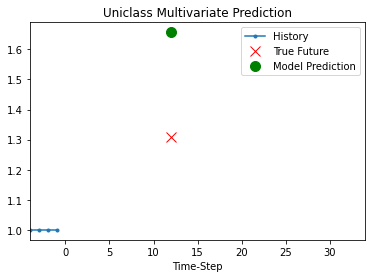

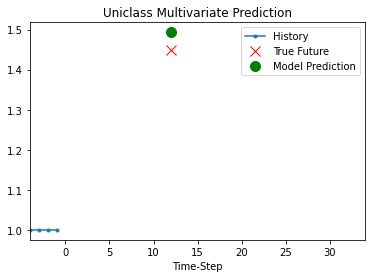

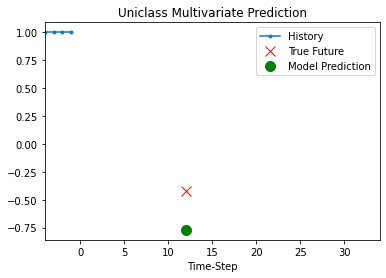

In [92]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Uniclass Multivariate Prediction')
  plot.show()

In [93]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(12, 1)


In [94]:
#Results from tensorflow
results = np.round(single_step_model.evaluate(x_val_single,y_val_single,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4254, Root Mean Squared Error 0.5953


### Cross-model evaluation
Predicting on 2019-20 test-set

In [95]:
score_model(y_val_single, x_val_single, single_step_model, api='tf')

test_y is a numpy array
Test Scores:
  Mean Absolute Error(MAE): 153.51630892072404
  Root Mean Squared Error(RMSE): 214.81452430562263
  Coefficient of Determination(R2): 0.5127300440635135
Take 4 Sample Comparison:
  Predictions: [1001  960  789  574]
      Actuals: [875 736 617 490]


## Multiclass - All blocks (Weekly)

Improvement in R2 and overall decrease in MAE & RMSE - best model, predictions for the first sample seem to be a little more in all cases

In [96]:
#import data
data = weekly.drop(columns=['calendar_day','year'])
data.index = weekly['calendar_day']
data.month = data.month.astype(float)

In [97]:
## select columns with highest correlation
columns = ['month','state_local_construction$B', 'carbon_bar_ship_canada','block', 
           'inventory_tons', 'production_tons', 'sale_order_tons', 'shipment_tons']

data = data[columns]
data.shape

(12519, 8)

### Checking Index for Split

In [98]:
#checking spot for train_split
TRAIN_SPLIT2 = 9455 #size of dataframe up to 2018
weekly.iloc[9454:9457,:]

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
9454,2018-12-30,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"6"" FLT",6793.732139,-2.0,290.1270,3.0
9455,2019-01-06,2019,1,0.7768,1601.0,18166.0,222800.0,34800.0,201600.0,34200.0,56.6,56.7,375.0,"1"" FLT",0.004000,0.0,15.0590,3.0
9456,2019-01-06,2019,1,0.7768,1601.0,18166.0,222800.0,34800.0,201600.0,34200.0,56.6,56.7,375.0,"5"" CHN",4213.412014,-9.0,110.9505,39.0


### Transforming Variables

In [99]:
scale_x = StandardScaler() 
scale = StandardScaler()
min_max = MinMaxScaler()
one_hot = OneHotEncoder(sparse=False)

#fitting
month = min_max.fit_transform(data['month'].to_numpy().reshape(-1, 1))
block = one_hot.fit_transform(data['block'].to_numpy().reshape(-1,1))
#note only fitting on training
scale_x.fit(data[0:TRAIN_SPLIT2][data.columns.drop(['month','block','shipment_tons'])])
scale.fit(data[0:TRAIN_SPLIT2]['shipment_tons'].to_numpy().reshape(-1,1))
values = scale_x.transform(data[data.columns.drop(['month','block','shipment_tons'])])
y = scale.transform(data['shipment_tons'].to_numpy().reshape(-1,1))

In [100]:
#Prepared dataframe
data_prepared = np.concatenate([month,block,values,y], axis=1)

In [101]:
data_prepared.shape

(12519, 82)

### Train-Test Split

In [102]:
#data split for all blocks by time frame
past_history = 260 # 4 weeks of data (~65 blocks/week X 4 weeks )
future_target = 260 # how far out do we want to forecast 0-> next week
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_multi, y_train_multi = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT2, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT2, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [103]:
print ('Single window of train past history : {}'.format(x_train_multi[0].shape))
print ('Single window of prediction past history : {}'.format(x_val_multi[0].shape))

Single window of train past history : (260, 82)
Single window of prediction past history : (260, 82)


### Setting Up Model

In [104]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 780 #3 times the size of the past_history
BUFFER_SIZE = 10000 #size of data to shuffle, should be set slightly larger or equal to dataset size

##NEED TO LOOK UP AND EXPLAIN THIS
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi)) #Creates tensor slices of data for keras model ingestion
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #stores slices of data in cache, shuffles and stores to size batches 

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat() 

In [106]:
#deleting saved model for re-runs 
#del single_step_multiclass #(TURN-OFF FIRST INSTANCE)
#creating model architecture
single_step_multiclass = keras.models.Sequential()
single_step_multiclass.add(keras.layers.LSTM(328, input_shape=x_train_multi.shape[-2:])) # number of variables * 4
single_step_multiclass.add(keras.layers.Dense(1)) #only one output layer

single_step_multiclass.compile(optimizer=keras.optimizers.RMSprop(), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Training Model

In [107]:
#parameters
EPOCHS=3 #number of times to run train 
EVALUATION_INTERVAL=12 #how many steps are taken during epoch - 3 years worth of data(9600 points) divided by steps of 780 points (8/weeks)

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_multiclass.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=4)

Train for 12 steps, validate for 4 steps
Epoch 1/3
12/12 [==============================] - 381s 32s/step - loss: 0.4897 - root_mean_squared_error: 1.0638 - val_loss: 0.4661 - val_root_mean_squared_error: 0.9191
Epoch 2/3
12/12 [==============================] - 360s 30s/step - loss: 0.4303 - root_mean_squared_error: 1.0539 - val_loss: 0.4248 - val_root_mean_squared_error: 0.9735
Epoch 3/3
12/12 [==============================] - 345s 29s/step - loss: 0.4272 - root_mean_squared_error: 1.0569 - val_loss: 0.4167 - val_root_mean_squared_error: 0.9792


### Scoring Model

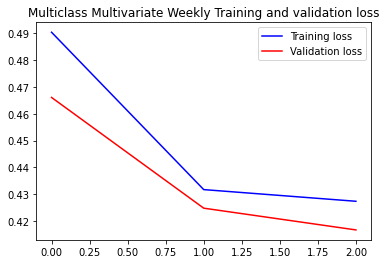

In [108]:
#Plotting loss curves
plot_train_history(single_step_history,
                   'Multiclass Multivariate Weekly Training and Validation loss')

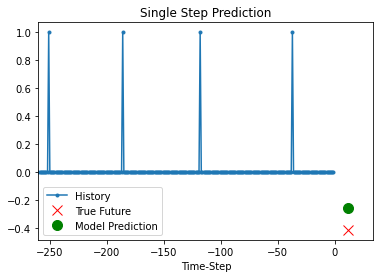

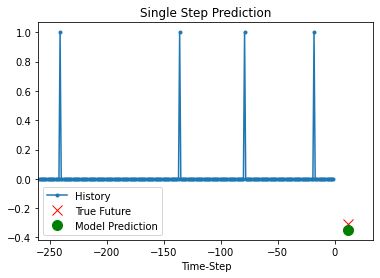

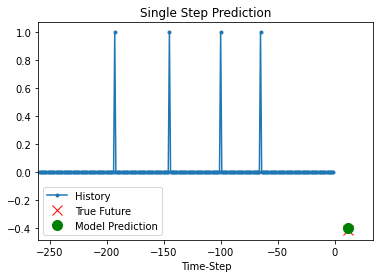

In [109]:
#Plotting prediction/actuals
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_multiclass.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [110]:
#Results from tensorflow
results = np.round(single_step_multiclass.evaluate(x_val_multi,y_val_multi,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4313, Root Mean Squared Error 0.9792


### Cross-model evaluation
Predicting on 2019-20 test-set

In [111]:
score_model(y_val_multi,x_val_multi,single_step_multiclass,api='tf')

test_y is a numpy array
Test Scores:
  Mean Absolute Error(MAE): 52.24185408554177
  Root Mean Squared Error(RMSE): 118.61552791672925
  Coefficient of Determination(R2): -0.17045658204704872
Take 4 Sample Comparison:
  Predictions: [19 16 14 18]
      Actuals: [  0   0 357   4]


## Multiclass - All blocks (Monthly)

While the MAE & RMSE scores may seem to impress, the R2 scores is alarming and the small sample of predictions versus actuals may indicate that the model is missing some high shipment up-ticks. While more data (multi-class: different blocks) is being supplied to the model in hopes it will lead to greater interpretation, it seems that sparse low weekly shipments amounts may affecting models ability to capture up-ticks

In [112]:
#import data
data = monthly.drop(columns=['calendar_day','year'])
data.index = monthly['calendar_day']
data.month = data.month.astype(float)

In [113]:
## select columns with highest correlation
columns = ['month','state_local_construction$B', 'carbon_bar_ship_canada','block', 
           'inventory_tons', 'production_tons', 'sale_order_tons', 'shipment_tons']

data = data[columns]
data.shape

(2936, 8)

### Checking Index for Split

In [114]:
#checking spot for train_split
TRAIN_SPLIT2 = 2190 #size of dataframe up to 2018
monthly.iloc[2189:2192,:]

,calendar_day,year,month,global_steel_utilization,fed_construction$B,state_local_construction$B,carbon_bar_ship_usa,carbon_bar_ship_canada,structural_ship_usa,structural_ship_canada,ism_manufacturing,ism_non_manufacturing,chicago_scrap$ST,block,inventory_tons,production_tons,sale_order_tons,shipment_tons
2189,2018-12-31,2018,12,0.7620,1783.0,19153.0,177300.0,21900.0,174200.0,25500.0,54.3,58.0,405.0,"6"" FLT",26724.19121,1741.0,755.0565,279.0
2190,2019-01-31,2019,1,0.7768,1601.0,18166.0,222800.0,34800.0,201600.0,34200.0,56.6,56.7,375.0,"9"" FLT",0.31200,0.0,0.0000,0.0
2191,2019-01-31,2019,1,0.7768,1601.0,18166.0,222800.0,34800.0,201600.0,34200.0,56.6,56.7,375.0,PR 3/8,-0.04800,0.0,0.0000,0.0


### Transforming Variables

In [115]:
scale_x = StandardScaler()
scale = StandardScaler()
min_max = MinMaxScaler()
one_hot = OneHotEncoder(sparse=False)

#fitting
month = min_max.fit_transform(data['month'].to_numpy().reshape(-1, 1))
block = one_hot.fit_transform(data['block'].to_numpy().reshape(-1,1))
#note only fitting numerical on training
scale_x.fit(data[0:TRAIN_SPLIT2][data.columns.drop(['month','block','shipment_tons'])])
scale.fit(data[0:TRAIN_SPLIT2]['shipment_tons'].to_numpy().reshape(-1,1))
values = scale_x.transform(data[data.columns.drop(['month','block','shipment_tons'])])
y = scale.transform(data['shipment_tons'].to_numpy().reshape(-1,1))

In [116]:
#Prepared dataframe
data_prepared = np.concatenate([month,block,values,y], axis=1)

In [117]:
data_prepared.shape

(2936, 82)

### Train-Test Split

In [118]:
past_history = 65 # 1 month of data (~65 blocks/month)
future_target = 65 # how far out do we want to forecast 0-> next month
STEP = 1 # more than one if we don't want use all the data points in the sample

x_train_multi, y_train_multi = multivariate_data(data_prepared, data_prepared[:, -1], 0,
                                                   TRAIN_SPLIT2, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_multi, y_val_multi = multivariate_data(data_prepared, data_prepared[:, -1],
                                               TRAIN_SPLIT2, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [119]:
print ('Single window of train past history : {}'.format(x_train_multi[0].shape))
print ('Single window of prediction past history : {}'.format(x_val_multi[0].shape))

Single window of train past history : (65, 82)
Single window of prediction past history : (65, 82)


### Setting Up Model

In [120]:
#setting batch size for 3 months (the size of a production cycle)
BATCH_SIZE = 195 #3 times the size of the past_history
BUFFER_SIZE = 3000 #size of data to shuffle, should be set slightly larger or equal to dataset size

#creates the memory storage
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi)) #Creates tensor slices of data for keras model ingestion
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat() #stores slices of data in cache, shuffles and stores to size batches 

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat() 

In [121]:
#deleting saved model for re-runs 
#del single_step_multiclass #(TURN-OFF FIRST INSTANCE)
#creating model architecture
single_step_multiclass = keras.models.Sequential()
single_step_multiclass.add(keras.layers.LSTM(328, input_shape=x_train_multi.shape[-2:])) # number of variables * 4
single_step_multiclass.add(keras.layers.Dense(1)) #only one output layer

single_step_multiclass.compile(optimizer=keras.optimizers.RMSprop(), loss='mae', metrics=[tf.keras.metrics.RootMeanSquaredError()])

### Training Model

In [122]:
#parameters
EPOCHS=8 #number of times to run train 
EVALUATION_INTERVAL=12 #how many steps are taken during epoch - 3 years worth of data(2300 training points) divided by steps of 195 points (3 months)

#clearing weights and any other remnants from models-past
keras.backend.clear_session()
#fitting the model
single_step_history = single_step_multiclass.fit(train_data_multi, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_multi,
                                            validation_steps=4)

Train for 12 steps, validate for 4 steps
Epoch 1/8
12/12 [==============================] - 16s 1s/step - loss: 0.5675 - root_mean_squared_error: 1.0668 - val_loss: 0.4374 - val_root_mean_squared_error: 0.9992
Epoch 2/8
12/12 [==============================] - 14s 1s/step - loss: 0.4983 - root_mean_squared_error: 1.0529 - val_loss: 0.4209 - val_root_mean_squared_error: 1.0132
Epoch 3/8
12/12 [==============================] - 13s 1s/step - loss: 0.5214 - root_mean_squared_error: 1.1013 - val_loss: 0.4016 - val_root_mean_squared_error: 0.9936
Epoch 4/8
12/12 [==============================] - 11s 950ms/step - loss: 0.4893 - root_mean_squared_error: 1.0749 - val_loss: 0.4016 - val_root_mean_squared_error: 0.9725
Epoch 5/8
12/12 [==============================] - 15s 1s/step - loss: 0.5043 - root_mean_squared_error: 1.0635 - val_loss: 0.4147 - val_root_mean_squared_error: 1.0105
Epoch 6/8
12/12 [==============================] - 16s 1s/step - loss: 0.5016 - root_mean_squared_error: 1.0962

### Scoring Model

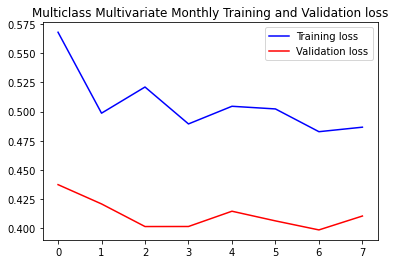

In [123]:
plot_train_history(single_step_history,
                   'Multiclass Multivariate Monthly Training and Validation loss')

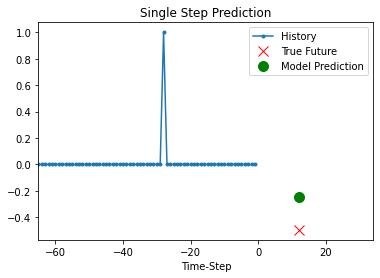

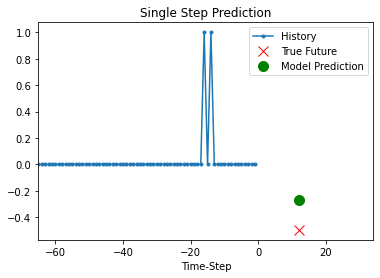

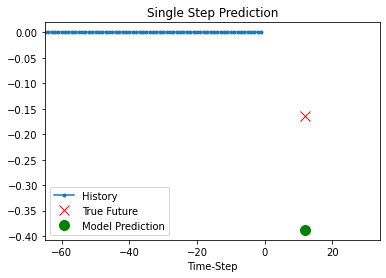

In [124]:
for x, y in val_data_multi.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_multiclass.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [125]:
#Results from tensorflow
results = np.round(single_step_multiclass.evaluate(x_val_multi,y_val_multi,BATCH_SIZE,verbose=0),4)
print("Mean Absolute Error {}, Root Mean Squared Error {}".format(results[0],results[1]))

Mean Absolute Error 0.4882, Root Mean Squared Error 0.9568


### Cross-model evaluation
Predicting on 2019-20 test-set

In [126]:
score_model(y_val_multi,x_val_multi,single_step_multiclass,api='tf')

test_y is a numpy array
Test Scores:
  Mean Absolute Error(MAE): 213.35602977678374
  Root Mean Squared Error(RMSE): 418.1633353728724
  Coefficient of Determination(R2): -0.11009802165000804
Take 4 Sample Comparison:
  Predictions: [109  91 114 100]
      Actuals: [ 0 25  3  0]


In this model we tried to increase the low individual shipment amounts that may occur weekly by aggregating the model to monthly values - thinking this may give more significant values for our model to interpret. While this does seem to have elevated the individual prediction values it does not seem to have helped but rather hurt our scores and coefficient of determination.

Moving forward, further cleaning removing irregular block sizes that are none-frequent production to see if that could help the prediction of these multi-class models or seeking for alternative architectures that may be able to use these multi-class data to increase the size of the data points could be a path to further explore